# Поиск похожих слов с использованием word2vec 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
random.seed(1228)

%matplotlib inline

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [3]:
data = pd.read_csv("../data/articles_lemmatized_noSW.csv")

In [4]:
data.head()

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый год накануне февраль возникать сложный ...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто


In [5]:
texts = []
for index, row in data.iterrows():
    try:
        texts.append(row.body.split())
    except:
        continue

Обучение модели:

In [6]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("izv_w2v.model")

Using TensorFlow backend.


CPU times: user 2min 23s, sys: 1.22 s, total: 2min 24s
Wall time: 55 s


Загружаем обученную модель (для скорости):

In [7]:
from gensim.models import Word2Vec
model = Word2Vec.load("izv_w2v.model") 

    1. Найдите синонимы для какого-нибудь слова:

In [8]:
model.most_similar("страна")

[('государство', 0.6696363687515259),
 ('россия', 0.6397303342819214),
 ('республика', 0.5664802193641663),
 ('регион', 0.5645366907119751),
 ('китай', 0.5515356659889221),
 ('континент', 0.544224739074707),
 ('израиль', 0.5277646780014038),
 ('турция', 0.5267192125320435),
 ('евросоюз', 0.5261290073394775),
 ('украина', 0.5256229639053345)]

    2. Найдите ассоциации вида (мужчина : король = женщина : королева)

In [9]:
model.most_similar(positive=["путин","сша"], negative=["россия"])

[('обама', 0.48815885186195374),
 ('американский', 0.48328208923339844),
 ('клинтон', 0.4396011233329773),
 ('серенко', 0.42783939838409424),
 ('алекно', 0.42554742097854614),
 ('чиркин', 0.41950422525405884),
 ('рожанковский', 0.4194791913032532),
 ('трамп', 0.4142455756664276),
 ('комоед', 0.40998363494873047),
 ('сафронок', 0.4091516435146332)]

    3. Задайте список слов и найдите лишнее в нем:

In [10]:
model.doesnt_match("борщ сметана макароны пирожок консомэ кошка".split())

'кошка'

    4. Создайте список top_words и запишите в него N самых частых слов

In [11]:
N = 
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(N):
    top_words.append(i[0])
print(top_words)

['год', 'россия', 'российский', 'сообщать', 'человек', 'президент', 'страна', 'заявлять', 'становиться', 'известие', 'время', 'рф', 'новый', 'сша', 'глава', 'отмечать', 'слово', 'такой', 'первый', 'рубль', 'один', 'работа', 'быть', 'москва', 'дело', 'вопрос', 'ранее', 'получать', 'решение', 'компания', 'читать', 'принимать', 'должный', 'представитель', 'сказать', 'место', 'отношение', 'другой', 'день', 'украина', 'владимир', 'результат', 'напоминать', 'организация', 'самый', 'происходить', 'сторона', 'считать', 'рассказывать', 'этот', 'город', 'проект', 'однако', 'проводить', 'система', 'международный', 'являться', 'говорить', 'область', 'находиться', 'путин', 'мнение', 'ситуация', 'мир', 'данные', 'информация', 'военный', 'правительство', 'число', 'регион', 'очень', 'проходить', 'власть', 'ребенок', 'суд', 'государство', 'составлять', 'вс', 'новость', 'главный', 'работать', 'случай', 'тот', 'сергей', 'команда', 'последний', 'большой', 'агентство', 'министр', 'сирия', '-', 'американски

    5. Постройте семантическую карту и найдите на ней интересные кластеры слов 

In [12]:
top_words_vec = model[top_words]

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

    6. Кластеризуйте эмбеддинги, постройте дендрограмму и найдите интересные кластеры 

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

In [15]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

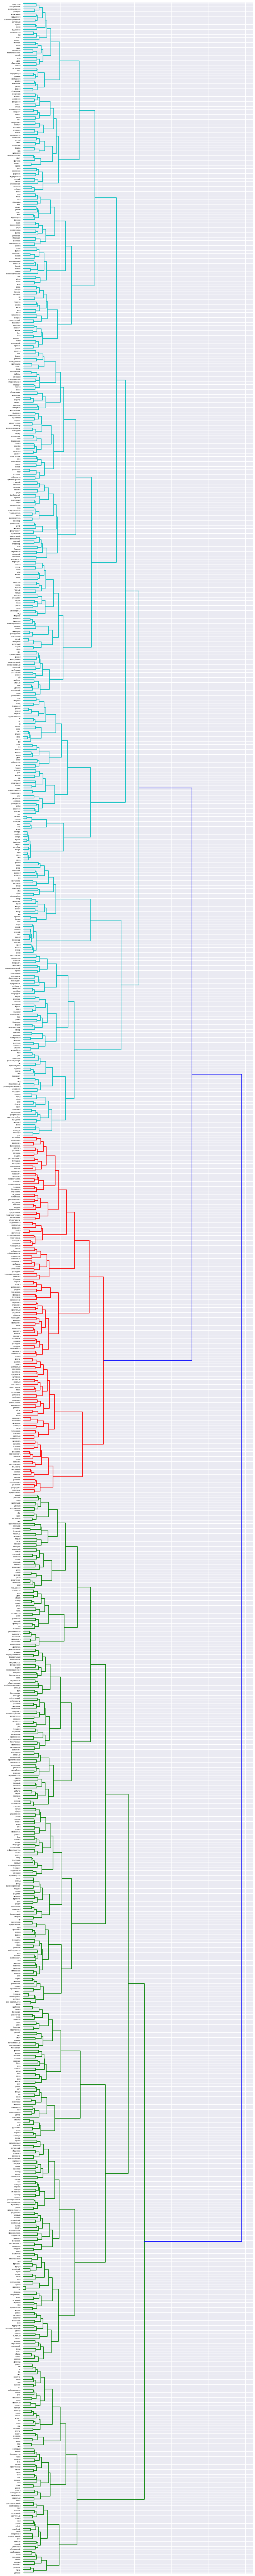

In [16]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters